Importing all necesary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Modela
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

Retrieve the list of images from the '/content/images/images' directory and displaying first 5

In [ ]:
img_filenames = os.listdir(r"C:\Users\shahe\Desktop\Predict-Cloudburst\images")
img_filenames[:5]

['10.png', '100.png', '101.png', '102.png', '103.png']

Making a dataframe with Id and path of images

In [28]:
img_filenames_df = pd.DataFrame({'Id':[x.split('.')[0] for x in img_filenames],
'Path':['Predict-Cloudburst\images' + x for x in img_filenames]})
img_filenames_df['Id'] = img_filenames_df['Id'].astype('int64')
img_filenames_df

,Id,Path
0,10,Predict-Cloudburst\images10.png
1,100,Predict-Cloudburst\images100.png
2,101,Predict-Cloudburst\images101.png
3,102,Predict-Cloudburst\images102.png
4,103,Predict-Cloudburst\images103.png
...,...,...
147,95,Predict-Cloudburst\images95.png
148,96,Predict-Cloudburst\images96.png
149,97,Predict-Cloudburst\images97.png
150,98,Predict-Cloudburst\images98.png


Read ERA5 data from .csv file as a dataframe

In [34]:
colnames_era5=['Id', 'Latitude', 'Longitude', '2mtemperature', 'Totalprecipitation', 'Label']
cloudburst_era5_df = pd.read_excel("DS img/DS tab.xlsx", names=colnames_era5)
cloudburst_era5_df['Id'] = cloudburst_era5_df['Id'].astype('int64')
cloudburst_era5_df['Label'] = cloudburst_era5_df['Label'].astype('int64')
cloudburst_era5_df.head()

,Id,Latitude,Longitude,2mtemperature,Totalprecipitation,Label
0,2,29.73,80.93,287.816307,0.002758,1
1,3,29.73,80.93,287.590995,0.002124,1
2,4,29.73,80.93,288.161543,0.002638,1
3,5,29.73,80.93,287.775726,0.003334,1
4,6,29.73,80.93,287.762402,0.003881,1


Merge ERA5 and image dataframes to a new one

In [35]:
img_era5_merged_df = pd.merge(left=img_filenames_df, right=cloudburst_era5_df, on='Id', how='inner')
img_era5_merged_df

,Id,Path,Latitude,Longitude,2mtemperature,Totalprecipitation,Label
0,10,Predict-Cloudburst\images10.png,29.73,80.93,287.459563,1.931187e-03,3
1,100,Predict-Cloudburst\images100.png,28.23,80.43,303.219905,3.920874e-04,2
2,101,Predict-Cloudburst\images101.png,28.23,80.43,301.733020,4.336809e-19,3
3,102,Predict-Cloudburst\images102.png,28.23,80.43,303.397953,2.294250e-06,3
4,103,Predict-Cloudburst\images103.png,28.23,80.43,303.255620,4.336809e-19,3
...,...,...,...,...,...,...,...
147,95,Predict-Cloudburst\images95.png,29.48,79.93,298.140453,1.260000e-04,1
148,96,Predict-Cloudburst\images96.png,29.48,79.93,299.199511,3.930000e-04,1
149,97,Predict-Cloudburst\images97.png,29.48,79.93,299.084431,1.410566e-03,1
150,98,Predict-Cloudburst\images98.png,29.48,79.93,301.952579,1.220000e-04,1


Delete latitude and longitude columns from the merged dataframe

In [36]:
img_era5_merged_df = img_era5_merged_df.drop(['Latitude', 'Longitude'], axis=1)
img_era5_merged_df = img_era5_merged_df.rename(columns={'2mtemperature':'two_m_temperature'})
img_era5_merged_df.head()

,Id,Path,two_m_temperature,Totalprecipitation,Label
0,10,Predict-Cloudburst\images10.png,287.459563,1.931187e-03,3
1,100,Predict-Cloudburst\images100.png,303.219905,3.920874e-04,2
2,101,Predict-Cloudburst\images101.png,301.733020,4.336809e-19,3
3,102,Predict-Cloudburst\images102.png,303.397953,2.294250e-06,3
4,103,Predict-Cloudburst\images103.png,303.255620,4.336809e-19,3


Create a new column in the df containing npz paths (npz file contains RGB array of pic and corresonding temperature and precipitation data)

In [ ]:

img_era5_merged_df['Path'] = img_era5_merged_df['Id'].apply(
    lambda x: rf"C:\Users\shahe\Desktop\Predict-Cloudburst\images\{x}.png"
)
# each id build path 

print("Checking paths...")
for path in img_era5_merged_df['Path'].head():
    print(path, "✅" if os.path.exists(path) else "❌")

npz_paths = []
for row in img_era5_merged_df.itertuples():
    picture_path = row.Path
    npz_path = picture_path.split('.')[0] + '.npz'
    npz_paths.append(npz_path)

    pic_bgr_arr = cv2.imread(picture_path)
    if pic_bgr_arr is None:
        print("❌ Could not load:", picture_path)
        continue

    pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)

    temp, prep = row.two_m_temperature, row.Totalprecipitation
    stats = np.array([temp, prep])
    label = row.Label

    np.savez_compressed(npz_path, pic=pic_rgb_arr, stats=stats, label=label)

img_era5_merged_df['NPZ_Path'] = pd.Series(npz_paths)

img_era5_merged_df.head()


Checking paths...
C:\Users\shahe\Desktop\Predict-Cloudburst\images\10.png ✅
C:\Users\shahe\Desktop\Predict-Cloudburst\images\100.png ✅
C:\Users\shahe\Desktop\Predict-Cloudburst\images\101.png ✅
C:\Users\shahe\Desktop\Predict-Cloudburst\images\102.png ✅
C:\Users\shahe\Desktop\Predict-Cloudburst\images\103.png ✅


,Id,Path,two_m_temperature,Totalprecipitation,Label,NPZ_Path
0,10,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...,287.459563,1.931187e-03,3,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...
1,100,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...,303.219905,3.920874e-04,2,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...
2,101,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...,301.733020,4.336809e-19,3,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...
3,102,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...,303.397953,2.294250e-06,3,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...
4,103,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...,303.255620,4.336809e-19,3,C:\Users\shahe\Desktop\Predict-Cloudburst\imag...


Make a new dataframe containing only temp and precipitation to calculate different statistics

In [49]:
era5_stats_df = img_era5_merged_df[['two_m_temperature', 'Totalprecipitation']]
era5_stats_df

,two_m_temperature,Totalprecipitation
0,287.459563,1.931187e-03
1,303.219905,3.920874e-04
2,301.733020,4.336809e-19
3,303.397953,2.294250e-06
4,303.255620,4.336809e-19
...,...,...
147,298.140453,1.260000e-04
148,299.199511,3.930000e-04
149,299.084431,1.410566e-03
150,301.952579,1.220000e-04


Create two lists containing avg and std dev respectively of temperature and preciptation


In [50]:
means_temp_prec = [era5_stats_df[col].mean() for col in era5_stats_df]
print(means_temp_prec)

std_devs_temp_prec = [era5_stats_df[col].std() for col in era5_stats_df]
print(std_devs_temp_prec)

[288.6167795503463, 0.0009317199588214388]
[27.137997998650086, 0.001696112990960555]


Load a sample satellite image from the .npz file created in earlier step and visualize

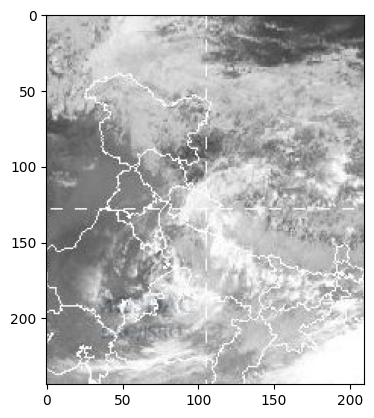

In [53]:
npz_img_sample = np.load(r"C:\Users\shahe\Desktop\Predict-Cloudburst\images\2.npz")
npz_img_sample ['pic'].shape, npz_img_sample ['stats'].shape
plt.imshow(npz_img_sample ['pic'])

Create a subset of img_era5_merged_df with image id, label and npz_paths to perform model training and testing

In [54]:
img_prop_path_df = img_era5_merged_df[['Id', 'Label', 'NPZ_Path']]
label_data_type = img_prop_path_df['Label'].dtype

Shuffle the dataframe created in above step. Then create train, validation and test dataframe containing first 130 rows, 131 to 142 rows and remaining rows respectively

In [55]:
shuffled_img_df = img_prop_path_df.sample(frac=1)
train_img_df, val_img_df, test_img_df = shuffled_img_df[:130], shuffled_img_df[130:142], shuffled_img_df[142:]
len(train_img_df), len(val_img_df), len(test_img_df)

(130, 12, 10)

Create a function to load images and get rgb values, corresponding temp and prec, and image labels

In [ ]:
def get_training_data(df, img_size=(224,224)):         
    x_img, x_stats, y = [], [], []
# npz_path

    for path in df['NPZ_Path']:
        if not os.path.exists(path):
            print("❌ File not found:", path)
            continue

        data = np.load(path)
        img = data['pic']

        # Resize image
        img_resized = cv2.resize(img, img_size)

        # Ensure 3 channels
        if len(img_resized.shape) == 2:
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
        # store list
        x_img.append(img_resized)
        x_stats.append(data['stats'])
        y.append(data['label'])
    # cont numpy arr
    x_img = np.array(x_img, dtype=np.float32)
    x_stats = np.array(x_stats, dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    return (x_img, x_stats), y


In [86]:
from sklearn.model_selection import train_test_split

Get training data (rgb values, label, prec, temp) from the train df and print the shape of the data arrays

In [108]:
(x_all_img, x_all_stats), y_all = get_training_data(train_img_df, img_size=(224,224))

x_train_img, x_val_img, x_train_stats, x_val_stats, y_train, y_val = train_test_split(
    x_all_img, x_all_stats, y_all, test_size=0.2, random_state=42, stratify=y_all
)


Get validation data (rgb values, label, prec, temp) from the val df and print the shape of the data arrays

In [109]:
(x_val_img, x_val_stats), y_val = get_training_data(val_img_df)
(x_val_img.shape, x_val_stats.shape), y_val.shape

(((12, 224, 224, 3), (12, 2)), (12,))

Get test data (rgb values, label, prec, temp) from the test df and print the shape of the data arrays

In [110]:
(x_test_img, x_test_stats), y_test = get_training_data(test_img_df)
(x_test_img.shape, x_test_stats.shape), y_test.shape

(((10, 224, 224, 3), (10, 2)), (10,))

create a function to scale tensor using mean and std. deviation

In [ ]:
def stat_scaler(tensor, mean_list, std_dev_list):
  # fun name
  return (tensor - mean_list ) / std_dev_list

#  to stand the stati fea

Create the DL model to train combining a CNN and FNN, which will be used in next steps

In [ ]:
# Define the Picture (CNN) Stream
input_pic = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(preprocess_input)(input_pic)
x = MobileNetV2(input_shape=(224, 224, 3), include_top=False)(x)
x = layers.GlobalAveragePooling2D()(x)
# cont to 1d
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout for regularization / wrap img
x = Model(inputs=input_pic, outputs=x)

# Define the Stats (Feed-Forward) Stream
input_stats = layers.Input(shape=(2,))
y = layers.Lambda(stat_scaler, arguments={'mean_list':means_temp_prec,'std_dev_list':std_devs_temp_prec})(input_stats)
y = layers.Dense(128, activation="relu")(y)
y = layers.Dropout(0.3)(y)  # Add dropout for regularization
y = Model(inputs=input_stats, outputs=y)

# Concatenate the two streams together
combined = layers.concatenate([x.output, y.output])

# Define output node for classification with 4 classes (0-3)
z = layers.Dense(4, activation="softmax")(combined)

# Define the final model
model = Model(inputs=[x.input, y.input], outputs=z)

# print the model summary
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ lambda_4[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 2)         │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │        384 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 4)         │      1,540 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,587,844 (9.87 MB)

 Trainable params: 2,553,732 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

Define a optimizer (Adam) to train the model and compile model

In [113]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

cp = ModelCheckpoint('model/best_model.keras', save_best_only=True)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [114]:
import cv2
import numpy as np

def resize_images(x_img, target_size=(224, 224)):
    resized_imgs = []
    for img in x_img:
        img_resized = cv2.resize(img, target_size)  # width x height
        resized_imgs.append(img_resized)
    return np.array(resized_imgs, dtype=np.float32)

# Resize training images
x_train_img = resize_images(x_train_img, target_size=(224, 224))
x_val_img = resize_images(x_val_img, target_size=(224, 224))


In [115]:
# Example: if your labels are 1,2,3,4 → map to 0,1,2,3
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

In [116]:
num_classes = len(np.unique(y_train))  # e.g., 5 if labels go 0-4
output = Dense(num_classes, activation='softmax')(combined)


In [117]:
print("y_train min/max:", y_train.min(), y_train.max())
print("y_val min/max:", y_val.min(), y_val.max())

y_train min/max: 0 3
y_val min/max: 0 3


Train the compiled model for 10 epochs (on training images and corresponding temp, prec data) and run the model on validation dataset. Get train and validation loss and accuracy



In [119]:
history = model.fit(
    x=[x_train_img, x_train_stats],
    y=y_train,
    validation_data=([x_val_img, x_val_stats], y_val),
    epochs=10,
    callbacks=[cp]
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9436 - loss: 0.1779 - val_accuracy: 0.6667 - val_loss: 7.4132
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9544 - loss: 0.1223 - val_accuracy: 0.7500 - val_loss: 4.1444
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9589 - loss: 0.1356 - val_accuracy: 0.7500 - val_loss: 1.7561
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9766 - loss: 0.0715 - val_accuracy: 0.9167 - val_loss: 0.6991
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9885 - loss: 0.1255 - val_accuracy: 0.6667 - val_loss: 1.0655
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9603 - loss: 0.1668 - val_accuracy: 0.8333 - val_loss: 0.4057
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9788 - loss: 0.0973 - val_accuracy: 0.9167 - val_loss: 0.1988
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9718 - loss: 0.0681 - val_accuracy: 0.9167 - val_loss: 0.5565
Epoch 9/

get the model loss and accuracy for training and validation from model history

In [120]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy']) * 100.0
validation_accuracy = np.array(history.history['val_accuracy']) * 100.0

Plot the training and validation loss and accuracy for each epoch (to check if model accuracy is increasing with each epoch)

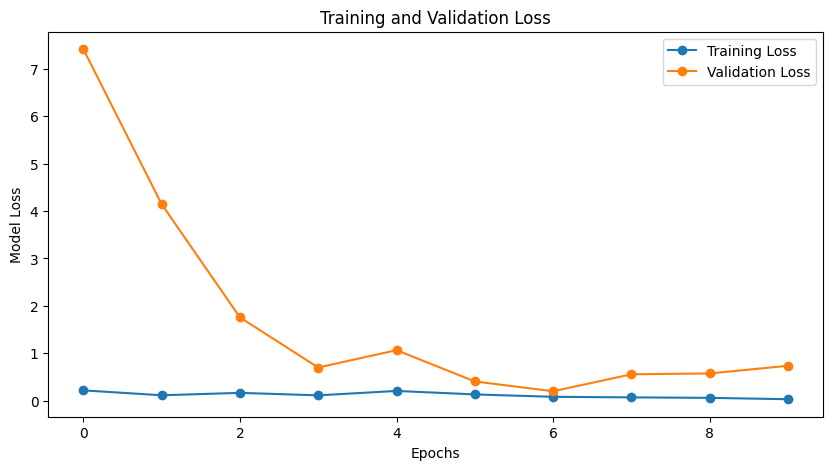

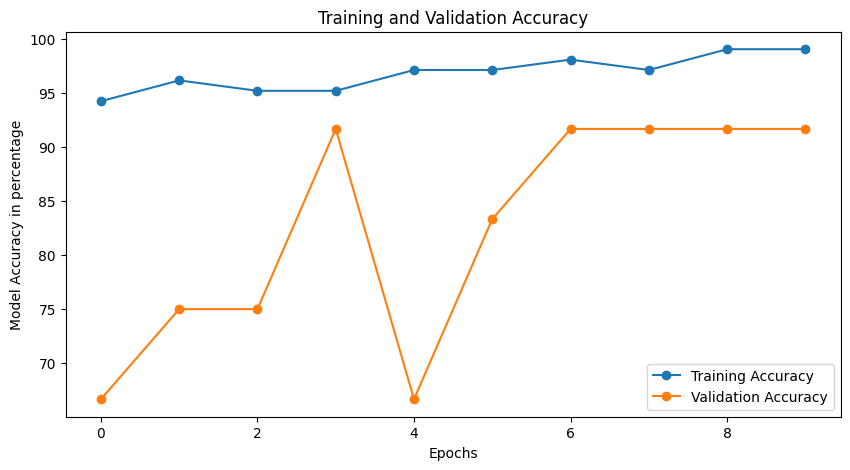

In [121]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(validation_loss, label='Validation Loss', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

#Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy', linestyle='-', marker='o')
plt.plot(validation_accuracy, label='Validation Accuracy', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy in percentage')
plt.legend(loc="best")
plt.title('Training and Validation Accuracy')
plt.show()

Now test the trained model on test dataset and check how accurately our model is trained to predict cloud burst events

In [122]:
test_loss, test_accuracy = model.evaluate(
    x=[x_test_img, x_test_stats],
    y=y_test
)

print(f'The accuracy of the trained model on test dataset is {test_accuracy * 100.0}%')
print(f'The loss of the trained model on test dataset is {test_loss}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - accuracy: 0.6000 - loss: 3.2098
The accuracy of the trained model on test dataset is 60.00000238418579%
The loss of the trained model on test dataset is 3.2097911834716797


In [124]:
# Save entire model
model.save('model/my_model.keras')  # use .keras extension